## Abundance analysis of overlapping and unique species from PGE

In [88]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ranksums

### Load data

In [29]:
# Load files
tax_PGE = pd.read_csv('../../Data/PGE/PGE_taxonomic_table.csv')
tax_NOPGE = pd.read_csv('../../Data/NO_PGE/NO_PGE_taxonomic_table.csv')
abund_PGE = pd.read_csv('../../Data/PGE/PGE_abundance_table_filtered.csv')
abund_NOPGE = pd.read_csv('../../Data/NO_PGE/NO_PGE_abundance_table_filtered.csv')

shared_species = pd.read_csv('../../Output/Best_nets/otu_overlap_airbiome_cclasso_05_nosinglet.csv', header=None)[0].tolist()
unique_pge_species = pd.read_csv('../../Output/Best_nets/unique_pge_otus_cclasso_05_nosinglet.csv', header=None)[0].tolist()

In [32]:
# Merge taxonomy with abundance tables
abund_PGE_tax = abund_PGE.merge(tax_PGE, on='OTU')
abund_NOPGE_tax = abund_NOPGE.merge(tax_NOPGE, on='OTU')

### Subset abundance tables

In [79]:
# Filter OTUs for shared species
shared_PGE = abund_PGE_tax[abund_PGE_tax['Species'].isin(shared_species)].copy()
shared_NOPGE = abund_NOPGE_tax[abund_NOPGE_tax['Species'].isin(shared_species)].copy()

# Filter OTUs for unique PGE species
unique_PGE = abund_PGE_tax[abund_PGE_tax['Species'].isin(unique_pge_species)].copy()
unique_PGE_in_NOPGE = abund_NOPGE_tax[abund_NOPGE_tax['Species'].isin(unique_pge_species)].copy()

### Aggregate at species level

In [90]:
def aggregate_by_species(df):
    # Drop OTU, group by Species and sum
    return df.groupby('Species').sum()

# Get abundance columns only
abund_cols_shared_PGE = [col for col in shared_PGE.columns if col not in ['OTU', 'Genus', 'taxonomy_id']]
abund_cols_shared_NOPGE = [col for col in shared_NOPGE.columns if col not in ['OTU', 'Genus', 'taxonomy_id']]
abund_cols_unique_PGE = [col for col in unique_PGE.columns if col not in ['OTU', 'Genus', 'taxonomy_id']]
abund_cols_unique_NOPGE = [col for col in unique_PGE_in_NOPGE.columns if col not in ['OTU', 'Genus', 'taxonomy_id']]

shared_PGE_agg = aggregate_by_species(shared_PGE[abund_cols_shared_PGE])
shared_NOPGE_agg = aggregate_by_species(shared_NOPGE[abund_cols_shared_NOPGE])
unique_PGE_agg = aggregate_by_species(unique_PGE[abund_cols_unique_PGE])
unique_PGE_in_NOPGE_agg = aggregate_by_species(unique_PGE_in_NOPGE[abund_cols_unique_NOPGE])

# Convert to relative abundance per sample (column-wise)
shared_PGE_rel = shared_PGE_agg.div(shared_PGE_agg.sum(axis=0), axis=1)
shared_NOPGE_rel = shared_NOPGE_agg.div(shared_NOPGE_agg.sum(axis=0), axis=1)

### Reshape for plotting

In [91]:
# Stack data for plotting: Species, Sample, Abundance, Condition
def melt_and_label(df, condition):
    # Transpose so columns are samples, then melt
    df_t = df.T.reset_index().rename(columns={'index': 'Sample'})
    long_df = df_t.melt(id_vars='Sample', var_name='Species', value_name='Abundance')
    long_df['Condition'] = condition
    return long_df

shared_long = pd.concat([
    melt_and_label(shared_PGE_agg, 'PGE'),
    melt_and_label(shared_NOPGE_agg, 'NOPGE')
])

shared_long_rel = pd.concat([
    melt_and_label(shared_PGE_rel, 'PGE'),
    melt_and_label(shared_NOPGE_rel, 'NOPGE')
])

unique_long = pd.concat([
    melt_and_label(unique_PGE_agg, 'PGE'),
    melt_and_label(unique_PGE_in_NOPGE_agg, 'NOPGE')
])


### Plots

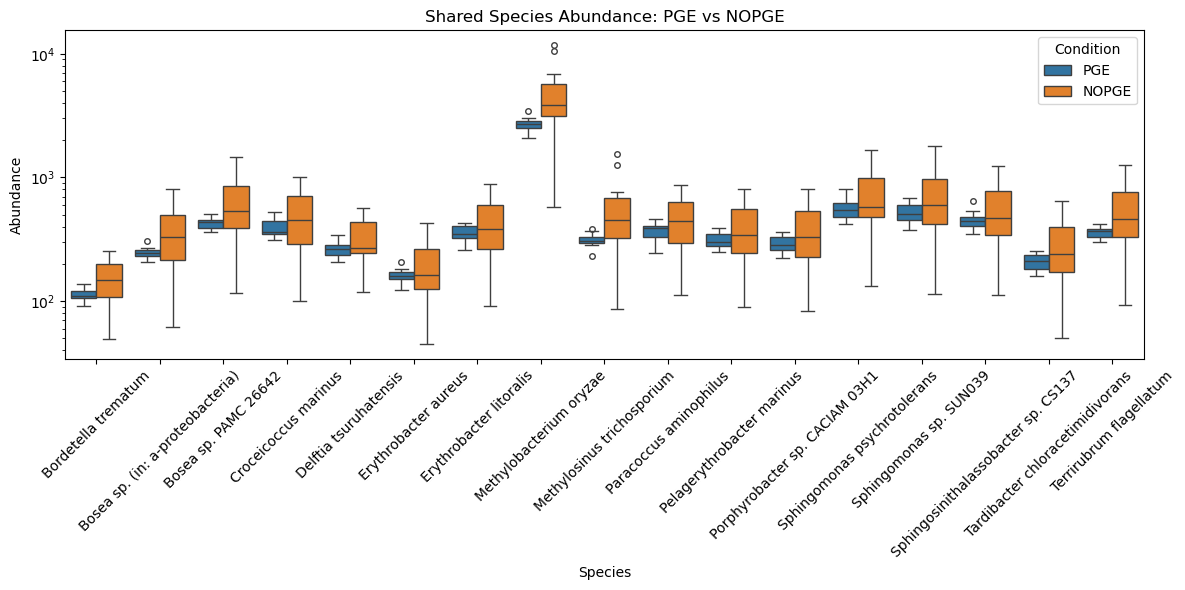

In [92]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=shared_long, x='Species', y='Abundance', hue='Condition', fliersize=4)
plt.yscale('log')
plt.xticks(rotation=45)
plt.title('Shared Species Abundance: PGE vs NOPGE')
plt.tight_layout()
plt.show()

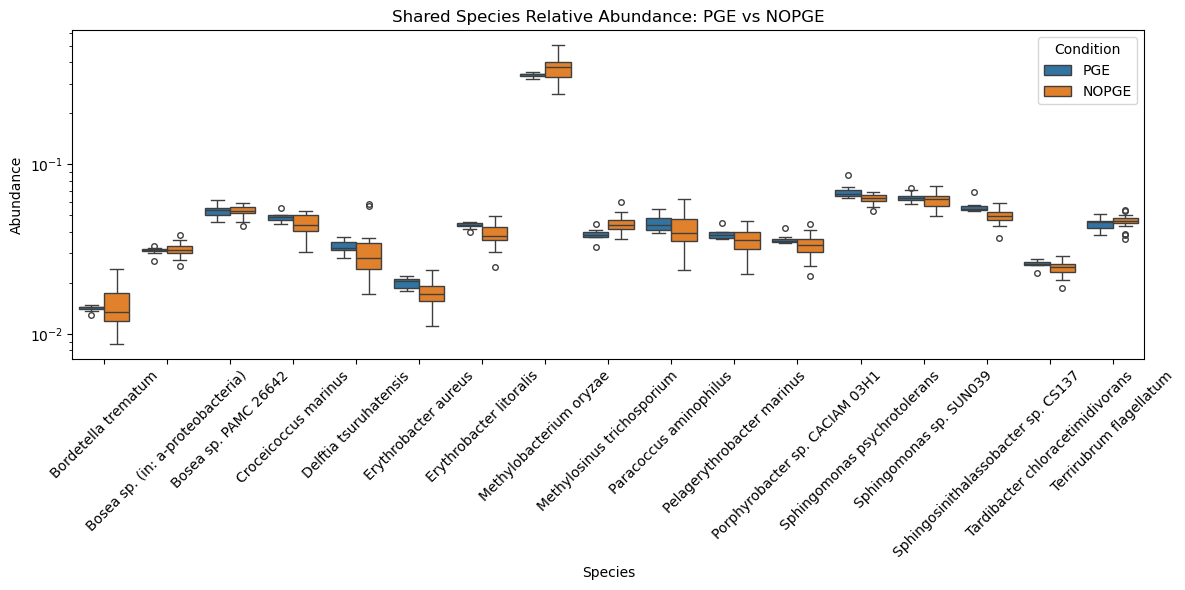

In [93]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=shared_long_rel, x='Species', y='Abundance', hue='Condition', fliersize=4)
plt.yscale('log')  # Still use log scale — many species will have low relative abundance
plt.xticks(rotation=45)
plt.title('Shared Species Relative Abundance: PGE vs NOPGE')
plt.tight_layout()
plt.show()

### Wilcoxon rank-sum test
Compare statistical difference on the abundance of species on PGE and non-PGE groups

In [72]:
stats_results = []
for sp in shared_PGE_agg.index:
    vals1 = shared_PGE_agg.loc[sp]
    vals2 = shared_NOPGE_agg.loc[sp]
    stat, p = ranksums(vals1, vals2)
    stats_results.append({'Species': sp, 'p_value': p})

stats_df = pd.DataFrame(stats_results)
stats_df['adj_p'] = stats_df['p_value'] * len(stats_df)  # Bonferroni correction
stats_df.sort_values('adj_p', inplace=True)
stats_df.reset_index(drop=True)

,Species,p_value,adj_p
0,Methylosinus trichosporium,0.025904,0.440365
1,Methylobacterium oryzae,0.043736,0.743516
2,Bordetella trematum,0.121711,2.069090
3,Terrirubrum flagellatum,0.121711,2.069090
4,Bosea sp. (in: a-proteobacteria),0.166515,2.830759
5,Bosea sp. PAMC 26642,0.173818,2.954898
6,Tardibacter chloracetimidivorans,0.360449,6.127639
7,Sphingomonas sp. SUN039,0.398579,6.775838
8,Paracoccus aminophilus,0.439040,7.463679
9,Sphingomonas psychrotolerans,0.439040,7.463679


In [85]:
stats_results = []
for sp in unique_PGE_agg.index:
    vals1 = unique_PGE_agg.loc[sp]
    vals2 = unique_PGE_in_NOPGE_agg.loc[sp]
    stat, p = ranksums(vals1, vals2)
    stats_results.append({'Species': sp, 'p_value': p})

stats_df = pd.DataFrame(stats_results)
stats_df['adj_p'] = stats_df['p_value'] * len(stats_df)  # Bonferroni correction
stats_df.sort_values('adj_p', inplace=True)
stats_df.reset_index(drop=True)

,Species,p_value,adj_p
0,Cnuibacter physcomitrellae,0.046244,3.422043
1,Rhizobium sp. SYY.PMSO,0.082701,6.119904
2,Bosea sp. NBC_00550,0.091349,6.759822
3,Agromyces sp. LHK192,0.110818,8.200506
4,Starkeya sp. ORNL1,0.110818,8.200506
...,...,...,...
69,Termitidicoccus mucosus,0.467276,34.578459
70,Roseateles sp. DAIF2,0.511457,37.847819
71,Methylibium petroleiphilum,0.526654,38.972408
72,Erythrobacter sp. THAF29,0.557725,41.271659
